# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_192  P02458;P02458-1   18.209
Sample_147  C9J712;P35080     12.818
Sample_157  O75874            14.105
Sample_167  A0A075B6Q5        17.417
Sample_024  P04271            14.691
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_144  Q7Z5L0           15.606
Sample_163  P00352           15.017
Sample_082  P10124           17.503
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.419
            A0A075B6Q5                 12.416
            A0A075B6R2                 12.830
            A0A075B6S5                 13.009
            A0A087WSY4                 11.710
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.446
            Q9UI40;Q9UI40-2            11.422
            Q9UIW2                     12.220
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.967
            Q9UP79                     12.278
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.100,15.050,16.842,19.863,16.217,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.780,19.067,...,15.528,15.576,14.410,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.938,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.632,17.705,17.039,15.544,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.411,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.509,15.345,17.084,18.708,14.249,19.433,11.837,10.816
Sample_207,15.739,16.877,15.469,16.898,14.358,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.267,12.437,13.963,12.460,13.125,13.441,12.425,12.463,12.821,14.026
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.280,19.067,16.127,...,12.602,11.579,12.907,11.850,12.708,12.642,12.624,12.914,14.229,11.043
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.327,13.460,12.127,12.063,11.536,11.141,12.823,12.473,14.358,13.157
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.955,12.663,13.520,13.738,12.325,12.147,12.937,12.004,13.154,12.700
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.033,12.946,12.718,12.954,13.269,13.764,12.777,13.019,13.236,13.580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,10.772,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 363.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.73it/s]

100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.53it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

100%|██████████| 4/4 [00:00<00:00,  3.84it/s]

100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.37it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.02it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.52it/s]

100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

100%|██████████| 5/5 [00:01<00:00,  4.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.81it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.70it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.07it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.95it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.14it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.64it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.95it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.93it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.82it/s]

100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.13it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.97it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.60it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.15it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.98it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.82it/s]

100%|██████████| 8/8 [00:01<00:00,  3.82it/s]

100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.59it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.65it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.83it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.91it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.72it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

100%|██████████| 9/9 [00:02<00:00,  4.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.83it/s]

 30%|███       | 3/10 [00:00<00:01,  4.75it/s]

 40%|████      | 4/10 [00:00<00:01,  4.03it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.73it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.71it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.69it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.53it/s]

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.71it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.34it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.58it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.98it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.18it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.72it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.59it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.86it/s]

100%|██████████| 11/11 [00:02<00:00,  3.85it/s]

100%|██████████| 11/11 [00:02<00:00,  4.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.69it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.23it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.66it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.25it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.16it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.04it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.33it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.20it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.12it/s]

100%|██████████| 12/12 [00:02<00:00,  4.05it/s]

100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.96it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.33it/s]

 31%|███       | 4/13 [00:00<00:02,  4.13it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.49it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.38it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.21it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.93it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.78it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.47it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.51it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.53it/s]

100%|██████████| 13/13 [00:04<00:00,  2.60it/s]

100%|██████████| 13/13 [00:04<00:00,  2.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.95it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.19it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.07it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.19it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.23it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.42it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.50it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.50it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.64it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.72it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.66it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.70it/s]

100%|██████████| 14/14 [00:03<00:00,  3.88it/s]

100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.13it/s]

 20%|██        | 3/15 [00:00<00:02,  5.10it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.70it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.42it/s]

 40%|████      | 6/15 [00:01<00:02,  3.49it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.14it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.97it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.74it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.83it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.94it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.97it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.10it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.42it/s]

100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.034 0.008          0.555 0.447       0.068   
2             0.003 0.000      0.035 0.005          0.696 0.116       0.509   
3             0.003 0.002      0.036 0.006          0.710 0.120       0.613   
4             0.003 0.000      0.035 0.007          0.712 0.115       0.613   
5             0.003 0.000      0.034 0.001          0.703 0.095       0.651   
6             0.003 0.000      0.035 0.002          0.785 0.082       0.790   
7             0.003 0.000      0.035 0.004          0.782 0.082       0.789   
8             0.004 0.002      0.036 0.006          0.780 0.083       0.778   
9             0.004 0.002      0.036 0.006          0.778 0.085       0.782   
10            0.003 0.000      0.032 0.006          0.774 0.085       0.783   
11            0.003 0.000      0.032 0.002          0.790 0.088       0.795   
12            0.004 0.002      0.032 0.002          0.790 0.089       0.799   
13            0.004 0.001      0.041 0.015          0.792 0.088       0.794   
14            0.007 0.005      0.056 0.017          0.796 0.088       0.783   
15            0.005 0.003      0.043 0.020          0.788 0.087       0.783   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.071   0.117 0.113                  0.528 0.032        0.842   
2          0.107   0.579 0.084                  0.669 0.058        0.713   
3          0.131   0.647 0.094                  0.709 0.072        0.780   
4          0.107   0.652 0.086                  0.712 0.067        0.798   
5          0.116   0.670 0.082                  0.723 0.067        0.798   
6          0.111   0.783 0.074                  0.815 0.061        0.885   
7          0.106   0.781 0.070                  0.813 0.058        0.884   
8          0.105   0.774 0.069                  0.807 0.057        0.884   
9          0.112   0.775 0.077                  0.808 0.063        0.882   
10         0.109   0.773 0.074                  0.806 0.062        0.885   
11         0.105   0.788 0.075                  0.819 0.063        0.893   
12         0.101   0.790 0.073                  0.820 0.063        0.895   
13         0.102   0.788 0.074                  0.819 0.063        0.894   
14         0.100   0.784 0.070                  0.816 0.059        0.900   
15         0.096   0.781 0.070                  0.813 0.059        0.898   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.819 0.089        210.000 0.000  
2          0.083                  0.669 0.099        210.000 0.000  
3          0.079                  0.715 0.097        210.000 0.000  
4          0.072                  0.762 0.093        210.000 0.000  
5          0.068                  0.754 0.092        210.000 0.000  
6          0.053                  0.855 0.063        210.000 0.000  
7          0.053                  0.853 0.064        210.000 0.000  
8          0.054                  0.852 0.067        210.000 0.000  
9          0.055                  0.853 0.064        210.000 0.000  
10         0.055                  0.859 0.064        210.000 0.000  
11         0.054                  0.871 0.061        210.000 0.000  
12         0.056                  0.878 0.058        210.000 0.000  
13         0.055                  0.875 0.059        210.000 0.000  
14         0.054                  0.885 0.057        210.000 0.000  
15         0.054                  0.883 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 528.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.92it/s]

100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.58it/s]

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.44it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.59it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.13it/s]

100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.37it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.68it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.13it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.93it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

100%|██████████| 6/6 [00:01<00:00,  4.14it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.15it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.46it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.98it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.00it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.98it/s]

100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.81it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.10it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.45it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.05it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.06it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.22it/s]

100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

100%|██████████| 8/8 [00:02<00:00,  3.44it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.95it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.21it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.39it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.20it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.11it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.35it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.50it/s]

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.98it/s]

 30%|███       | 3/10 [00:00<00:01,  4.61it/s]

 40%|████      | 4/10 [00:01<00:01,  3.55it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.30it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.17it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.07it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.10it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.21it/s]

100%|██████████| 10/10 [00:02<00:00,  3.24it/s]

100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.30it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.48it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.15it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.07it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.01it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.96it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.72it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.92it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.05it/s]

100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.36it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.79it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.81it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.64it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.68it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.77it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.95it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.72it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.91it/s]

100%|██████████| 12/12 [00:03<00:00,  3.07it/s]

100%|██████████| 12/12 [00:03<00:00,  3.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.04it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.20it/s]

 31%|███       | 4/13 [00:01<00:02,  3.17it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.16it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.11it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.03it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.04it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.13it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.12it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.12it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.10it/s]

100%|██████████| 13/13 [00:04<00:00,  3.20it/s]

100%|██████████| 13/13 [00:04<00:00,  3.17it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.97it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.51it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.98it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.71it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.51it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.51it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.36it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.35it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.44it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.64it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.66it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.82it/s]

100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.62it/s]

 20%|██        | 3/15 [00:00<00:02,  4.33it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.67it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.46it/s]

 40%|████      | 6/15 [00:01<00:02,  3.15it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.27it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.29it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.28it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.19it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.20it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.96it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.74it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.59it/s]

100%|██████████| 15/15 [00:04<00:00,  2.59it/s]

100%|██████████| 15/15 [00:04<00:00,  3.08it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.045 0.016          0.137 0.306       0.018   
2             0.004 0.002      0.046 0.017          0.750 0.127       0.645   
3             0.006 0.005      0.061 0.021          0.758 0.094       0.696   
4             0.005 0.004      0.051 0.019          0.763 0.095       0.690   
5             0.006 0.005      0.052 0.023          0.756 0.102       0.693   
6             0.005 0.004      0.054 0.028          0.751 0.092       0.698   
7             0.005 0.005      0.045 0.027          0.798 0.092       0.767   
8             0.006 0.005      0.050 0.028          0.794 0.093       0.774   
9             0.004 0.004      0.042 0.022          0.791 0.094       0.772   
10            0.005 0.004      0.043 0.020          0.796 0.095       0.770   
11            0.004 0.003      0.038 0.010          0.796 0.100       0.750   
12            0.004 0.000      0.037 0.004          0.797 0.096       0.778   
13            0.006 0.004      0.054 0.020          0.802 0.098       0.782   
14            0.005 0.004      0.051 0.028          0.838 0.091       0.802   
15            0.005 0.003      0.048 0.019          0.842 0.084       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.043   0.030 0.072                  0.504 0.019        0.873   
2          0.123   0.684 0.095                  0.738 0.076        0.804   
3          0.115   0.721 0.088                  0.766 0.069        0.865   
4          0.112   0.720 0.088                  0.765 0.068        0.864   
5          0.138   0.716 0.099                  0.763 0.078        0.881   
6          0.132   0.717 0.091                  0.763 0.071        0.878   
7          0.111   0.776 0.076                  0.810 0.062        0.910   
8          0.111   0.779 0.082                  0.812 0.068        0.909   
9          0.112   0.776 0.081                  0.810 0.067        0.907   
10         0.108   0.777 0.078                  0.811 0.065        0.910   
11         0.118   0.766 0.088                  0.802 0.072        0.910   
12         0.123   0.781 0.085                  0.815 0.071        0.917   
13         0.112   0.786 0.079                  0.818 0.066        0.922   
14         0.111   0.814 0.080                  0.842 0.066        0.929   
15         0.107   0.813 0.077                  0.842 0.063        0.929   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.838 0.087        210.000 0.000  
2          0.073                  0.743 0.095        210.000 0.000  
3          0.056                  0.829 0.072        210.000 0.000  
4          0.058                  0.829 0.072        210.000 0.000  
5          0.052                  0.847 0.066        210.000 0.000  
6          0.052                  0.847 0.064        210.000 0.000  
7          0.046                  0.888 0.057        210.000 0.000  
8          0.049                  0.888 0.056        210.000 0.000  
9          0.049                  0.886 0.057        210.000 0.000  
10         0.049                  0.892 0.056        210.000 0.000  
11         0.048                  0.891 0.055        210.000 0.000  
12         0.046                  0.899 0.052        210.000 0.000  
13         0.044                  0.907 0.049        210.000 0.000  
14         0.042                  0.916 0.045        210.000 0.000  
15         0.042                  0.917 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1004.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 30.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.21it/s]

100%|██████████| 3/3 [00:00<00:00, 20.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.02it/s]

100%|██████████| 4/4 [00:00<00:00, 19.83it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.83it/s]

100%|██████████| 5/5 [00:00<00:00, 16.04it/s]

100%|██████████| 5/5 [00:00<00:00, 16.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.67it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.55it/s]

100%|██████████| 6/6 [00:00<00:00, 13.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.23it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.77it/s]

100%|██████████| 7/7 [00:00<00:00, 12.37it/s]

100%|██████████| 7/7 [00:00<00:00, 12.77it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.43it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.85it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.23it/s]

100%|██████████| 8/8 [00:00<00:00, 11.74it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.37it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.85it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.62it/s]

100%|██████████| 9/9 [00:00<00:00, 12.30it/s]

100%|██████████| 9/9 [00:00<00:00, 13.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.16it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.61it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.81it/s]

100%|██████████| 10/10 [00:00<00:00, 13.22it/s]

100%|██████████| 10/10 [00:00<00:00, 14.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.27it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.39it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.18it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.89it/s]

100%|██████████| 11/11 [00:00<00:00, 13.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.72it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.30it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.17it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.57it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.99it/s]

100%|██████████| 12/12 [00:00<00:00, 13.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 14.34it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.19it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.53it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.98it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.13it/s]

100%|██████████| 13/13 [00:01<00:00, 11.64it/s]

100%|██████████| 13/13 [00:01<00:00, 12.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.46it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.50it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.60it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.42it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.59it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.58it/s]

100%|██████████| 14/14 [00:01<00:00, 12.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.15it/s]

 33%|███▎      | 5/15 [00:00<00:00, 12.41it/s]

 47%|████▋     | 7/15 [00:00<00:00, 11.59it/s]

 60%|██████    | 9/15 [00:00<00:00, 10.00it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.70it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.51it/s]

100%|██████████| 15/15 [00:01<00:00,  9.47it/s]

100%|██████████| 15/15 [00:01<00:00, 10.21it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.048 0.016          0.000 0.000       0.000   
2             0.004 0.002      0.043 0.013          0.000 0.000       0.000   
3             0.005 0.004      0.052 0.022          0.335 0.337       0.066   
4             0.004 0.001      0.040 0.012          0.625 0.104       0.548   
5             0.006 0.004      0.052 0.024          0.629 0.105       0.557   
6             0.004 0.000      0.040 0.011          0.614 0.097       0.545   
7             0.005 0.005      0.049 0.020          0.624 0.093       0.543   
8             0.005 0.004      0.055 0.022          0.634 0.081       0.590   
9             0.006 0.005      0.059 0.030          0.655 0.085       0.602   
10            0.005 0.005      0.040 0.013          0.648 0.093       0.602   
11            0.007 0.006      0.068 0.030          0.675 0.095       0.622   
12            0.005 0.004      0.051 0.018          0.673 0.104       0.611   
13            0.006 0.005      0.055 0.023          0.671 0.107       0.609   
14            0.004 0.003      0.041 0.013          0.654 0.102       0.590   
15            0.006 0.005      0.051 0.021          0.656 0.104       0.586   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.730   
2          0.000   0.000 0.000                  0.500 0.000        0.575   
3          0.074   0.101 0.102                  0.500 0.029        0.562   
4          0.130   0.577 0.101                  0.653 0.076        0.738   
5          0.132   0.584 0.103                  0.658 0.077        0.735   
6          0.116   0.572 0.094                  0.646 0.072        0.734   
7          0.107   0.575 0.085                  0.650 0.067        0.734   
8          0.119   0.606 0.089                  0.671 0.066        0.779   
9          0.123   0.622 0.089                  0.685 0.070        0.784   
10         0.117   0.619 0.091                  0.680 0.071        0.781   
11         0.124   0.640 0.092                  0.699 0.071        0.795   
12         0.112   0.635 0.091                  0.695 0.073        0.792   
13         0.115   0.632 0.091                  0.692 0.072        0.789   
14         0.116   0.614 0.092                  0.679 0.071        0.788   
15         0.114   0.612 0.091                  0.678 0.070        0.786   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.692 0.069        210.000 0.000  
2          0.103                  0.536 0.093        210.000 0.000  
3          0.080                  0.509 0.075        210.000 0.000  
4          0.075                  0.690 0.080        210.000 0.000  
5          0.076                  0.681 0.081        210.000 0.000  
6          0.069                  0.685 0.079        210.000 0.000  
7          0.073                  0.680 0.084        210.000 0.000  
8          0.070                  0.714 0.087        210.000 0.000  
9          0.075                  0.724 0.092        210.000 0.000  
10         0.075                  0.720 0.093        210.000 0.000  
11         0.069                  0.735 0.085        210.000 0.000  
12         0.069                  0.730 0.088        210.000 0.000  
13         0.068                  0.735 0.082        210.000 0.000  
14         0.070                  0.734 0.084        210.000 0.000  
15         0.069                  0.732 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,5,11
score_time,14,3,11
test_precision,14,15,11
test_recall,12,14,11
test_f1,12,14,11
test_balanced_accuracy,12,14,11
test_roc_auc,14,15,11
test_average_precision,14,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.34it/s]

 20%|██        | 3/15 [00:00<00:03,  3.14it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.98it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.98it/s]

 40%|████      | 6/15 [00:01<00:03,  2.94it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.90it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.84it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.45it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.37it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.34it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.27it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.33it/s]

100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

100%|██████████| 15/15 [00:05<00:00,  2.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.38it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.13it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.45it/s]

 91%|█████████ | 10/11 [00:00<00:00, 11.06it/s]

100%|██████████| 11/11 [00:00<00:00, 11.72it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.89it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.83it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.61it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.25it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.30it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.22it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.13it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.12it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.25it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.09it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.18it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.38it/s]

100%|██████████| 14/14 [00:04<00:00,  3.62it/s]

100%|██████████| 14/14 [00:04<00:00,  3.42it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


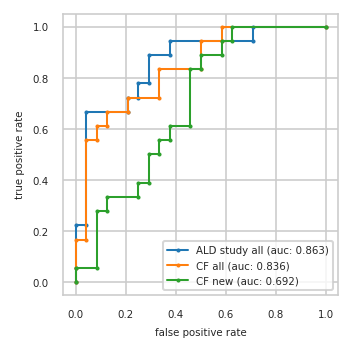

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.222  0.000 0.167  0.083 0.056
3          0.042 0.222  0.042 0.167  0.083 0.278
4          0.042 0.667  0.042 0.556  0.125 0.278
5          0.208 0.667  0.083 0.556  0.125 0.333
6          0.208 0.722  0.083 0.611  0.250 0.333
7          0.250 0.722  0.125 0.611  0.250 0.389
8          0.250 0.778  0.125 0.667  0.292 0.389
9          0.292 0.778  0.208 0.667  0.292 0.500
10         0.292 0.889  0.208 0.722  0.333 0.500
11         0.375 0.889  0.333 0.722  0.333 0.556
12         0.375 0.944  0.333 0.833  0.375 0.556
13         0.708 0.944  0.500 0.833  0.375 0.611
14         0.708 1.000  0.500 0.944  0.458 0.611
15         1.000 1.000  0.583 0.944  0.458 0.833
16           NaN   NaN  0.583 1.000  0.500 0.833
17           NaN   NaN  1.000 1.000  0.500 0.889
18           NaN   NaN    NaN   NaN  0.583 0.889
19           NaN   NaN    NaN   NaN  0.583 0.944
20           NaN   NaN    NaN   NaN  0.625 0.944
21           NaN   NaN    NaN   NaN  0.625 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YXX1,P22676,P42262;P42262-2;P42262-3
2,O75173;O75173-2;Q5VTW1,P31150,A0A0G2JLV7;A0A0G2JM94;A0A0G2JMI0;A0A0G2JNK8;A0...
3,P61981,Q14894,P30048;P30048-2
4,P14174,Q9Y2T3;Q9Y2T3-3,P51688
5,P04075,P63104,P31321
6,C9JF17;P05090,Q9HC57,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P00338;P00338-3,P04075,J3KSJ8;Q9UD71;Q9UD71-2
8,Q6EMK4,P61981,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


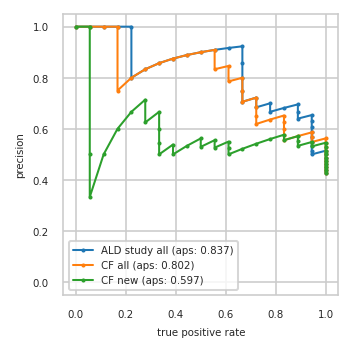

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.548 0.944     0.548 0.944
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.571 0.889     0.571 0.889
15         0.630 0.944     0.556 0.833     0.556 0.833
16         0.654 0.944     0.577 0.833     0.577 0.833
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.652 0.833     0.522 0.667
20         0.682 0.833     0.636 0.778     0.500 0.611
21         0.667 0.778     0.619 0.722     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.684 0.722     0.684 0.722     0.526 0.556
24         0.722 0.722     0.722 0.722     0.556 0.556
25         0.706 0.667     0.706 0.667     0.529 0.500
26         0.750 0.667     0.750 0.667     0.562 0.500
27         0.800 0.667     0.800 0.667     0.533 0.444
28         0.857 0.667     0.786 0.611     0.500 0.389
29         0.923 0.667     0.846 0.611     0.538 0.389
30         0.917 0.611     0.833 0.556     0.500 0.333
31         0.909 0.556     0.909 0.556     0.545 0.333
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     0.875 0.389     0.625 0.278
35         0.857 0.333     0.857 0.333     0.714 0.278
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


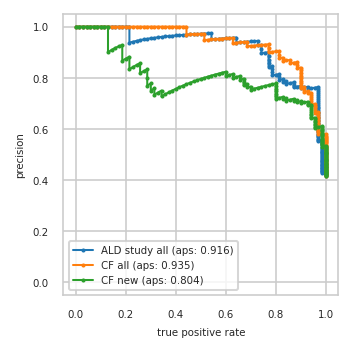

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


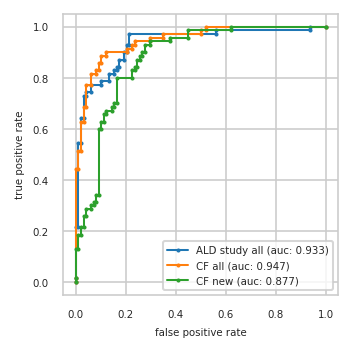

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}